In [1]:
#Import needed libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

**Exercise 1**

In [2]:
# Loads dataset from specified path. Returns data matrix X and labels y
def load_Xy(path):

    #Use built-in pandas function to read csv file into a dataframe
    df = pd.read_csv(path)

    #Convert the dataframe to a numpy array
    data_array = df.to_numpy()

    #Separate the features X from the labels y
    X = data_array[:,:-1]
    y = data_array[:,-1]

    #Replace the 0 label with -1
    y[y==0] = -1 

    #reshape y as a column vector
    y = y.reshape(y.shape[0],1)

    #return X and y
    return X,y


In [3]:
#Call the function and load the data
X,y = load_Xy('data.csv')

In [4]:
#Let's count how many malicious apps there are

# Filter the y array only where y == -1, then get its dimensions, and then its length
y[ y==-1 ].shape[0]

14632

 There are $14632$ malicious apps in the dataset

In [5]:
#Count how many non-zero entries are in X
non_zero_entries = X[X!=0].shape[0]

#Count total elements in X
tot_entries = X.shape[0]*X.shape[1]

print("Non-zero entries: {}".format(non_zero_entries))
print("Total entries: {}".format(tot_entries))
print("Ratio: {}".format(non_zero_entries/tot_entries))

Non-zero entries: 277180
Total entries: 2522552
Ratio: 0.10988078739308446


Only the $10\%$ of the elements of the matrix $X$ are non-zero, thus $X$ has a sparsity of $90\%$.

In [6]:
#Returns the set of unique elements in the matrix X
np.unique(X)

array([0, 1], dtype=int64)

As we can see from the previous line of code, the matrix elements are either 1s or 0s. One hot coding is typically used to translate categorical features into multiple features that can only assume value 1 or 0. However, the features of the data matrix already assume values $\in \{0,1\}$, thus there is no need to apply one-hot coding.

**Exercise 2**

In [7]:
# Splits the data matrix X and the labels y into train and test set, according to ratio r.
def train_test_split(X,y,r):

    #Check that r is between 0 and 1
    if not ( r > 0 and r < 1):
        print("Error: r must be between 0 and 1")
        return
        
    #get number of rows
    rows = X.shape[0]

    #create a indices array for the rows
    indices = [i for i in range(rows)]

    #shuffle the array randomly
    np.random.shuffle(indices)

    #Now that the indices are randomized, we can split in train and test
    train_indices = indices[:int(rows*r)]
    test_indices = indices[int(rows*r):]

    X_train = X[train_indices,:]
    X_test = X[test_indices,:]
    y_train = y[train_indices]  
    y_test = y[test_indices]
    
    return X_train, y_train, X_test, y_test


In [8]:
#Split the data matrix into 50% train set and 50% test set

X_train, y_train, X_test, y_test = train_test_split(X,y,0.5)

**Exercise 3**

Let $X \in \R^{n \times m}$ be the data matrix with data rows $x_i,\ldots, x_n, i = 1,\ldots, n$, vector $y \in \{-1,1\}^n$, and a weight vector $w \in \R^m$. If the product $y_i x_i w > 0$, the point is correctly classified, and if $y_i x_i w <0$, the point is misclassified. We count the points $x_i w = 0$ as misclassified, as there is no way of confirming its (mis)classification.

We define a function $f$ that assigns value $0$ to misclassified points, and $1$ for correctly classified points. Mathematically, this function would be defined as $f: \R \rightarrow \{0,1\}$:

$f(s) \coloneqq \frac{1}{2}(\text{sign}(s) + 1)$,

with $f(0) = 0$.

The function for the number of correctly classified points $F: \R^m \rightarrow \Z_{\geq 0}$ is then defined:

$F(w) = \sum_{i = 1} ^ n f(y_ix_iw)$.

Since Python does not have a sign function, we write a function that fulfills this task. 

We generate a random weight vector $w \in \R^m$ with values $w_j \in [-10,10), \forall j = 1,\ldots,m$, such that the chances of $w_j$ being positive or negative are equal and the chance of $w_j = 0$ is approximately zero, but we include a safety measure to stop the function in the case $w$ contains at least one $0$ element.

The function for the sum of correctly classified points is defined as:

In [9]:
# Classifies the data points. Assigns labels +1 or -1
def classify(X,w):

    # For each row of X, compute x_i'*w
    v = np.dot(X,w)

    #if it's > 0, replace with +1
    v[v > 0] = 1

    #replace with -1 otherwise
    v[v <= 0] = -1
    return v

#Returns number of correctly classified datapoints using weight w
def count_correctly_classified(X,y,w):
    v = classify(X,w)*y
    return len(v[v == 1])

In [10]:
w_rand = np.random.rand(X.shape[1],1)*2 - 1

print("Correctly classified points: {}/{}".format(count_correctly_classified(X,y,w_rand), y.shape[0]))

Correctly classified points: 15309/29332


Number of correctly classified points for a random weights vector oscillates around $50 \%$

**Exercise 4**

$X \in \mathbb{R}^{n \times d}$, $w \in \mathbb{R}^{d \times 1}$, $y \in \mathbb{R}^{n \times 1}$

The hinge-loss function for logistic regression is:

$f(s) = \log{(1+e^{-s})}$

That is making the cost function for a logistic regression be:

$J(\textbf{w}) = \sum_{i=1}^{n} \log{(1+e^{-y_i \textbf{x}_i^T \textbf{w}})} + \frac{\lambda}{2} \lVert \textbf{w} \rVert^2$

Therefore, the gradient of the cost function $J$ is:

$\nabla J (\textbf{w}) = \sum_{i=1}^{n} -\frac {e^{-y_i \textbf{x}_i^T \textbf{w}}} {1+e^{-y_i \textbf{x}_i^T \textbf{w}}} + \lambda \textbf{w}$

To calculate it, first we have considered $g(x) = \log {(1+e^{-x})}$ and $h_i (\textbf{w}) = y_i \textbf{x}i^T \textbf{w}$ as function such that $J(\textbf{w}) = \sum{i=1}^{n} g (h_i (\textbf{w}))$ and calculated the derivative of each function:

$g \prime (x) = - \frac {e^{-x}}  {1+e^{-x}} = - \frac {1} {1+e^{x}}\quad$ and $\quad\nabla h_i (\textbf{w}) = y_i \textbf{x}_i$

Then, due to the chain rule of the Jacobian, we determined the gradient of the cost function as:
$\nabla J (\textbf{w}) = \sum_{i=1}^{n} g \prime (y_i \textbf{x}_i^T \textbf{w}) \cdot \nabla h_i (\textbf{w})$ obtaining the formula above.

**Exercise 5 - Normal**

In [11]:
# Derivative of f(s) = log(1 + e^(-s))
def fprime(x):
    return -1/(1 + np.exp(x))

In [12]:
# Computes the gradient of J(w) using the formula derived earlier
def grad(X,y,w,a,l):
    return np.dot( np.transpose(X), y*fprime(y*np.dot(X,w)) ) + l*w

# Computes the cost function J(w)
def loss(X,y,w,l):
    return np.sum( np.log(np.exp(-y*np.dot(X,w)) + 1 ) ) + (np.linalg.norm(w)**2)*0.5*l

#Logistic regression function. a (alpha) is step size, l (lambda) is regularization parameter.
#N is number of iterations

def lr(X,y,a,l,N):

    #Generate a random initial weight vector
    w = np.random.rand(86,1)

    #Perform fixed step gradient descent
    for i in range(N):
        g = grad(X,y,w,a,l)
        w = w - a*g
    
    return w

In [13]:
w_ = lr(X_train,y_train,0.00003,15000,50)

In [14]:
train_acc = count_correctly_classified(X_test,y_test,w_)/y_test.shape[0]
train_acc

0.8460384562934679

**Exercise 5 - Sparse**

In [15]:
#Uses spare module from scipy library to further speed up computation
def grad_sparse(Xs,y,w,l):
    return  Xs.transpose()*(y*fprime(y*(Xs*w))) + l*w

def lr_sparse(X,y,a,l,N):
    #Converts data matrix into sparse format
    Xs = csr_matrix(X)

    #Generate random initial weight vector
    w = np.random.rand(86,1)

    for i in range(N):
        gradient = grad_sparse(Xs,y,w,l)
        w = w - a*gradient

    return w

In [16]:
# Different version of sparse logistic regression. 
# The algorithm stops either when
#   i) the norm of the gradient is smalled than threshold. This
#      indicates that the alogrithm has reached (almost) the minimum
#
#   ii) the number of iterations exceeds maxit
#
# Returns the weigth vector w and the number of iterations k
def lr_sparse_thr(X,y,a,l,threshold,maxit):
    Xs = csr_matrix(X)
    w = np.random.rand(86,1)

    #Ensures that at least the first iteration is performed
    grad_norm = threshold+1
    k = 0
    while grad_norm > threshold and k < maxit:
        g = grad_sparse(Xs,y,w,l)
        w = w - a*g
        grad_norm  = np.linalg.norm(g)
        k += 1

    return w,k

**Hyperparameter optimization**

In this section we search for optimal values of the hyperparameters $\lambda$ and $\alpha$, starting with $\lambda$.
Sparse linear algebra allows us to perform a large number of iterations in a reasonable time.
We can then choose small $\alpha$, so that the optimal point is reached with precision.

We first look for $\lambda$ in a logarithmic scale, ranging from $10^{-6}$ to $10^{6}$, comparing the accuracy of the models on the train and test datasets. We stop the algorithm if the gradient drops below a value of $0.01$.

In [ ]:
#choose small alpha and a large number of maximum iterations
alpha = 1e-4
maxit = 10000

#The algorithm stops when the norm of the gradient is smaller than grad_threshold
grad_threshold = 0.01

for lambda_ in [10**i for i in range(-6,6)]:
    w,k = lr_sparse_thr(X_train,y_train,alpha,lambda_,grad_threshold,maxit)
    train_acc = count_correctly_classified(X_train,y_train,w)/y_train.shape[0]
    test_acc = count_correctly_classified(X_test,y_test,w)/y_test.shape[0]
    print("Lambda: {}, iter: {}, train_acc: {}, test_acc: {}".format(lambda_, k, train_acc,test_acc))
    


Lambda: 1e-06, iter: 10000, train_acc: 0.9609982271921451, test_acc: 0.9582708304922951
Lambda: 1e-05, iter: 10000, train_acc: 0.9609982271921451, test_acc: 0.9583390154097914
Lambda: 0.0001, iter: 10000, train_acc: 0.9609982271921451, test_acc: 0.9583390154097914
Lambda: 0.001, iter: 10000, train_acc: 0.9607936724396563, test_acc: 0.9582026455747988
Lambda: 0.01, iter: 10000, train_acc: 0.9610664121096414, test_acc: 0.9584072003272877
Lambda: 0.1, iter: 10000, train_acc: 0.9610664121096414, test_acc: 0.9583390154097914
Lambda: 1, iter: 10000, train_acc: 0.9607254875221601, test_acc: 0.9584072003272877
Lambda: 10, iter: 7219, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Lambda: 100, iter: 957, train_acc: 0.9514523387426701, test_acc: 0.9501568253102414
Lambda: 1000, iter: 119, train_acc: 0.9375426155734351, test_acc: 0.9369289513159689
Lambda: 10000, iter: 10000, train_acc: 0.5080458202645575, test_acc: 0.5032046911223237


<ipython-input-11-cf7674abd114>:3: RuntimeWarning: overflow encountered in exp
  return -1/(1 + np.exp(x))


Lambda: 100000, iter: 321, train_acc: 0.0, test_acc: 0.0


<ipython-input-15-e216eb91c21d>:3: RuntimeWarning: overflow encountered in multiply
  return  Xs.transpose()*(y*fprime(y*(Xs*w))) + l*w
<ipython-input-16-c5cbba0be9fd>:18: RuntimeWarning: invalid value encountered in subtract
  w = w - a*g


From running these iterations, we argue that $\lambda < 100$ is a good regularization term that generalizes well and produces accurate local minimizers $w$. Therefore, we decided to fix $\lambda = 10$, and do the same iterations as above, this time to find an optimal learning rate $\alpha$.

In [21]:
#choose small alpha and a large number of maximum iterations
lambda_test = 10
maxit = 10000

#The algorithm stops when the norm of the gradient is smaller than grad_threshold
grad_threshold = 0.01

for alpha_ in [0.0001 + i*10**(-4) for i in range(0,9)]:
    w,k = lr_sparse_thr(X_train,y_train,alpha_,lambda_test,grad_threshold,maxit)
    train_acc = count_correctly_classified(X_train,y_train,w)/y_train.shape[0]
    test_acc = count_correctly_classified(X_test,y_test,w)/y_test.shape[0]
    print("Alpha: {}, iter: {}, train_acc: {}, test_acc: {}".format(alpha_, k, train_acc,test_acc))
    


Alpha: 0.0001, iter: 7058, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.0002, iter: 3611, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.00030000000000000003, iter: 2407, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.0004, iter: 1732, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.0005, iter: 1455, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.0006000000000000001, iter: 1184, train_acc: 0.9583390154097914, test_acc: 0.9577935360698213
Alpha: 0.0007000000000000001, iter: 10000, train_acc: 0.9513841538251738, test_acc: 0.9483158325378427
Alpha: 0.0008, iter: 10000, train_acc: 0.9585435701622801, test_acc: 0.9584072003272877
Alpha: 0.0009000000000000001, iter: 10000, train_acc: 0.9537706259375426, test_acc: 0.9528160370925951


From these iterations, we argue that our algorithm with a learning rate $\alpha = 0.0006$ converges in the least number of iterations (roughly $1200$ iterations), while maintaining high accuracy for finding the optimal local minimizer $w$.

We now have values for our hyperparameters $(\alpha, \lambda) = (0.0006, 10)$.

### Exercise 6

In [ ]:
#Load second dataset
X_2,y_2 = load_Xy('data2.csv')

#Function to compute k-reconstructed matrix 
def k_truncated_SVD(X,k):
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    U_k = U[:,:k]
    S_k = np.diag(S[:k]) 
    Vt_k = Vt [:k,:]
    return np.dot(U_k, np.dot(S_k, Vt_k))


Loop through different values of k, for example 85 down to 75. Compute the norm of of the differences between each datapoint. Then visualize the distribution of the errors.

k: 85


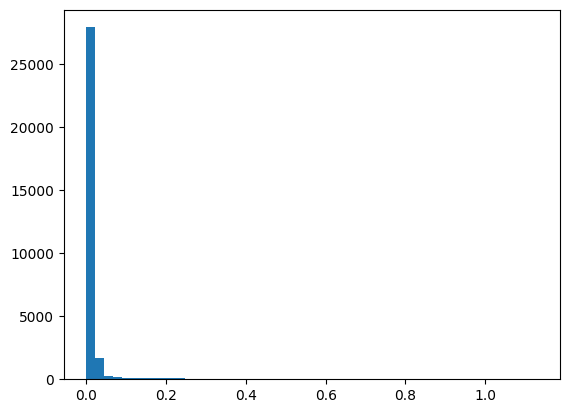

k: 80


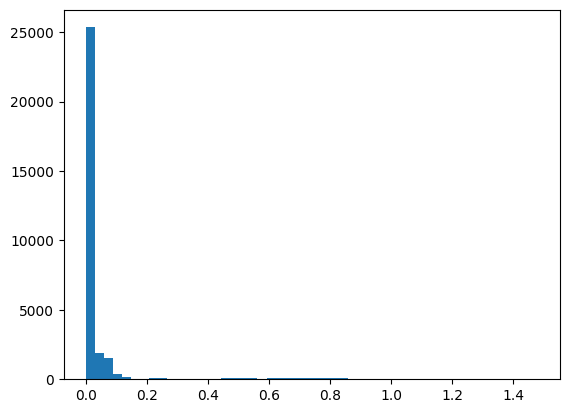

k: 75


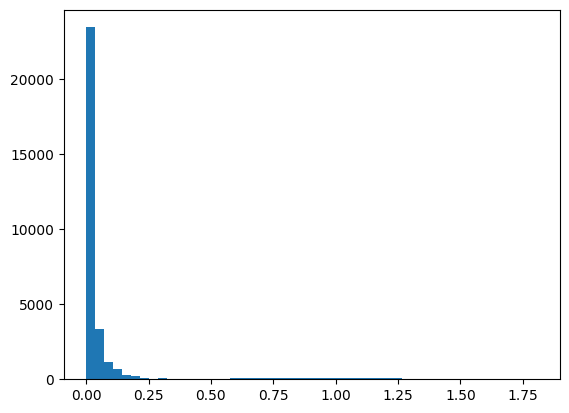

k: 70


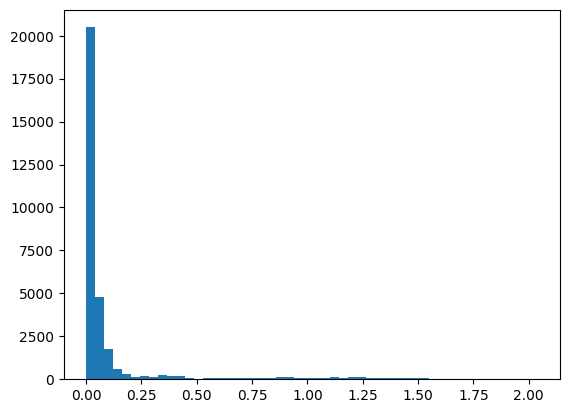

k: 65


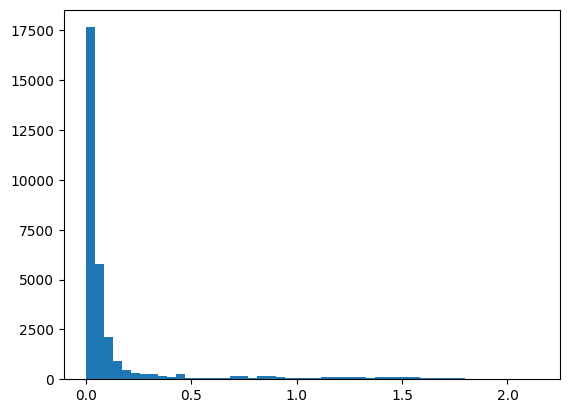

k: 60


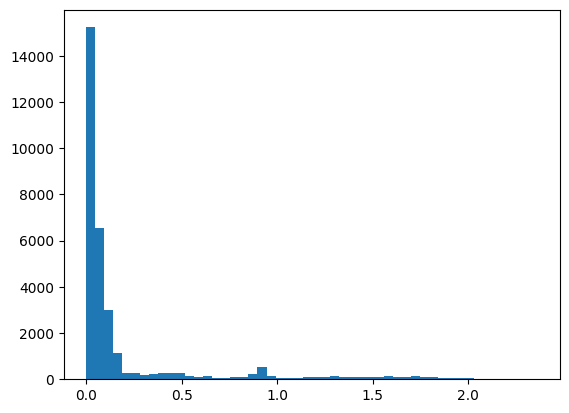

k: 55


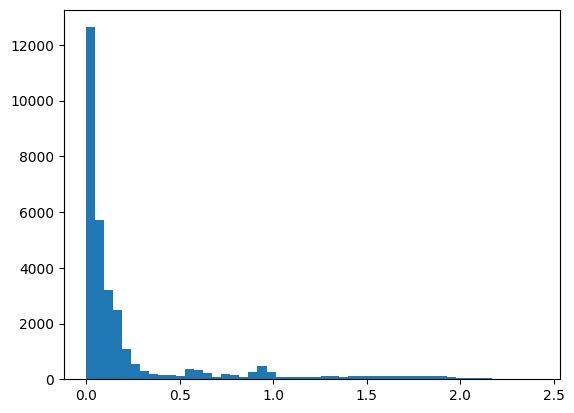

k: 50


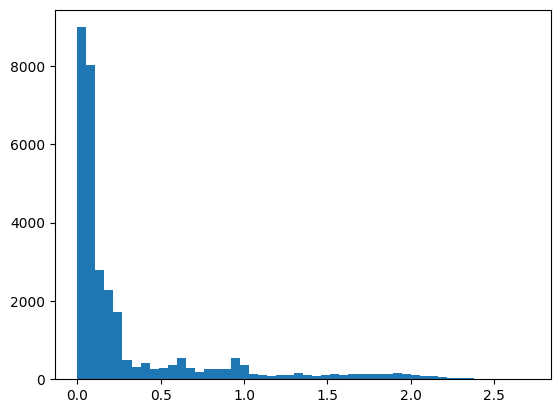

k: 45


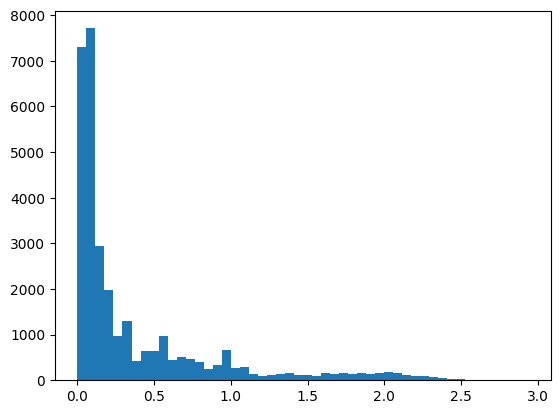

In [ ]:
for k in range(85,40,-5):
    X_2k = k_truncated_SVD(X_2,k)
    errors = np.sqrt(((X_2 - X_2k)**2).sum(axis=1))
    print("k: {}".format(k))
    plt.hist(errors,bins=50)
    plt.show()
    

We can see from the graphs that, as $k$ goes down, the distribution becomes more and more stretched. We (arbitrarily) define outliers as those datapoint whose errors is greater than 3 standard deviations. Since we know that there are 2000 outliers, we want to find the largest $k$ for which there are at least 2000 outliers:

In [ ]:
def detect_outliers(n):
    for k in range(85,10,-1):
        X_2k = k_truncated_SVD(X_2,k)
        errors = np.sqrt(((X_2 - X_2k)**2).sum(axis=1))
        std = errors.std()
        outliers = np.where(errors > 3*std)[0]
        if(len(outliers) > n):
            return k,outliers

In [ ]:
k, outliers = detect_outliers(2000)
print(len(outliers))
print(k)

2008
39


Now choose only 2000 of these outliers. Then remove them from the matrix X_2 and make a comparison with the dataset without outliers

In [ ]:
outliers = outliers[:2000]

mask = np.ones(X_2.shape[0], dtype=bool)
mask[outliers] = False

X_2_cleaned = X_2[mask]

In [ ]:
X_2_cleaned.shape

(29332, 86)

In [ ]:
np.linalg.norm(X_2_cleaned - X, ord='fro')

np.float64(488.1126919062851)

In [ ]:
for o in outliers:
    print(o)

70
109
159
218
295
360
469
500
532
536
739
768
780
804
837
861
950
970
1169
1176
1272
1345
1393
1448
1475
1497
1517
1521
1544
1615
1698
1794
1931
1934
2029
2106
2109
2274
2304
2324
2431
2516
2523
2537
2575
2581
2582
2663
2708
3000
3147
3327
3337
3338
3426
3483
3489
3562
3915
3916
3921
3989
4037
4065
4080
4150
4161
4175
4197
4204
4212
4390
4402
4482
4487
4507
4534
4606
4722
4747
4951
4978
5030
5126
5311
5323
5331
5441
5497
5517
5543
5559
5603
5731
5748
5862
5911
5976
5987
6097
6247
6251
6282
6293
6411
6552
6747
6801
6810
6896
6905
6983
6984
7061
7141
7229
7262
7313
7331
7340
7368
7401
7536
7645
7745
7773
7799
7822
7861
8061
8146
8239
8241
8245
8292
8379
8487
8506
8646
8764
8769
8909
9005
9030
9044
9210
9283
9401
9488
9599
9623
9648
9696
9713
9717
9744
9928
10007
10023
10044
10229
10259
10379
10466
10647
10677
10746
10775
10808
10856
11017
11041
11142
11212
11267
11306
11311
11312
11353
11360
11452
11483
11500
11591
11631
11684
11728
11729
11760
11782
11807
11860
11936
12112
12208
12225


The following two functions are defined as:

'**k_svd**': returns the $k$-truncated SVD of a matrix $X$.

'**detect_outliers**': returns an array containing the indices of all rows indicated as an outlier.

In [22]:
def k_svd (X, k):

    #Use the singular value decomposition numpy function to calculate the matrices U, Vt and the vector S of the eigenvalues of X 
    [U, S, Vt] = np.linalg.svd (X, full_matrices = False)

    #Consider the matrix U_k taking the first k columns of U
    U_k = U [:,0:k]
    #Consider the matrix Vt_k taking the first k rows of Vt
    Vt_k = Vt [0:k,:]
    #Consider the diagonal matrix Sigma_k taking the first k eigenvalues of X
    Sigma_k = np.diag (S[0:k])
    #Calculating the k-truncated svd matrices X_k
    X_k = np.dot ( U_k,  np.dot (Sigma_k, Vt_k) )

    return X_k

def detect_outliers (X, k, c):
    #create the k-truncated svd of X
    X_k = k_svd (X, k)

    #calculate the vector of the norm of the difference of the rows between X and X_k
    error = np.linalg.norm ( X - X_k, axis = 1 )

    #calculate the threshold
    #determine the mean of the vector of the error
    m = np.mean (error)
    #determine the variance of the vector of the error
    var = np.var ( error )
    #determine the threshold as the sum between the mean and 3 time the variance of the vector of the error
    threshold = m + c * var

    #determine the outlier as the indices where the error is above the threshold
    outlier = np.where (error > threshold)
    #redimension the dimension of the array
    outlier = np.array(outlier).flatten()

    return outlier

[X1, y1] = load_Xy ('data.csv')
n = X1.shape[0]
[X2,y2] = load_Xy ('data2.csv')

In [32]:
def analysis (k, c, n):
    outlier = detect_outliers(X2, k, c)
    m = len (outlier)

    v = np.arange (29332, 31331)
    tot = 0
    for i in v:
        if np.all( np.isin(i, outlier) ):
            tot = tot + 1

    a = tot / 2000
    b = ( m - tot ) / m
    d = ( m - tot ) / n

    #print ( "true outliers spotted: {}, fake outliers: {}, modified non-outliers: {}, dimension: {}".format (a, b, d, len (outlier)) )

    return [a, b, d, m]

analysis (82, 3, X1.shape[0])

[0.907, 0.1333014811275681, 0.009511795990726851, 2093]

In [24]:
def c_choice (k, n):
    tot_fake = 1
    c = 1
    j = 1

    while j < 20:
        [a,  b, d, m] = analysis (k, j, n)

        if m >= 2000:
            if (b < tot_fake):
                c = j
                tot_fake = b
        
        j = j+1
    
    return c-1

In [25]:
for k in [ 86-i for i in range (1,10) ]:
    c = c_choice (k, n)
    outlier = detect_outliers (X2, k, c)

    X_k = k_svd (X2, k)

    error_1 = np.linalg.norm ( X1 - X_k[0:n, :], ord = 'fro' ) / np.linalg.norm ( X1, ord = 'fro' )

    print("k: {}, error_1: {}, c: {}, dimension: {}".format(k, error_1, c, len (outlier) ) )

k: 85, error_1: 0.004748130079366776, c: 3, dimension: 2558
k: 84, error_1: 0.00717995852385509, c: 3, dimension: 2280
k: 83, error_1: 0.00882998820855122, c: 2, dimension: 2339
k: 82, error_1: 0.011660972376728855, c: 3, dimension: 2093
k: 81, error_1: 0.014261639750669007, c: 3, dimension: 2105
k: 80, error_1: 0.015583012793832179, c: 3, dimension: 2071
k: 79, error_1: 0.017132352094359274, c: 2, dimension: 2140
k: 78, error_1: 0.018800600502426757, c: 2, dimension: 2187
k: 77, error_1: 0.02042157646092112, c: 3, dimension: 2076


In [29]:
#the value k = 83 and c = 3 are considered to us valuable
def outlier_removal (X2, y2, k, c):
    outlier = detect_outliers (X2, k, c)
    X_k = k_svd (X2, k)

    X = np.delete (X_k, outlier, axis = 0)
    y = np.delete (y2, outlier, axis = 0)

    return X,y,len(outlier)

The function '**w_test_comparison**' below returns the percentage of correctly classified points in the test sets after training. It does so for the original dataset $X_1,\textbf{y}_1$ and the dataset $X_2, \textbf{y}_2$ after removing its outliers using the function '**outlier_removal**'. It also returns the number of removed outliers from $X_2,\textbf{y}_2$.

The inputs are $X_1,\textbf{y}_1$, $X_2,\textbf{y}_2$, a list of hyperparameters for logistic regression and values for the truncation of $X_2,y_2$.

In [ ]:
#hyperparameters: [alpha, lambda, gradient threshold, max # of iterations]
hyper = [0.0006, 10, 0.01, 4000]

#values for the truncation of X2,y2: [k, c]
outlier_coeff = [82, 3]

#comparison function
def w_test_comparison(X1,y1,X2,y2,hyper, outlier_coeff):
    #unpacks hyperparameters and values for the k-truncation
    a,l,thr,N = hyper
    k,c = outlier_coeff

    #makes a random 50/50 split of our original data set
    X_train, y_train, X_test, y_test = train_test_split(X1,y1,0.5)

    #removes outliers from the dataset with fake datapoints, and makes a random 50/50 split afterwards
    A,b,m = outlier_removal(X2,y2, k,c)
    A_train, b_train, A_test, b_test = train_test_split(A,b,0.5)

    #runs logistic regression algorithm with sparse linear algebra for both the original training set and the training set with removed outliers
    w = lr_sparse_thr(X_train, y_train, a,l,thr, N); w_A = lr_sparse_thr(A_train, b_train, a,l,thr, N)

    #Calculates the percentage of correctly classified points after calculating the local optimal weight vectors in logistic regression.
    acc = count_correctly_classified(X_test, y_test, w[0])/y_test.shape[0]*100
    acc_A = count_correctly_classified(A_test, b_test, w_A[0])/b_test.shape[0]*100

    #return the number of outliers and the test accuracies for X1 and truncated X2 with removed outliers.
    return m, acc, acc_A
m, acc, acc_A = w_test_comparison(X1,y1,X2,y2,hyper, outlier_coeff)
print("Test accuracy for X1: {}%, and for X2 after removal of {} points classified as outliers: {}%". format(acc, m, acc_A))


Test accuracy for X1: 95.63616528024002%, and for X2 after removal of 2093 points classified as outliers: 95.0547195622435%
